# South African Language Identification Hack 2022
***EDSA 2201 classification hackathon***

**James Beta**

In [1]:
import pandas as pd
import numpy as np
import string
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

In [2]:
df_train = pd.read_csv('train_set.csv')
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [3]:
df_train.shape

(33000, 2)

In [4]:
def clean_title(title): 
    title = re.sub('<.*?>', ' ', title)
    #pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+' #Pattern to remove all hyperlinks
    #title = re.sub(pattern_url,' ',title)    
    #title = re.sub('RT @.*:','',title)    
    title = re.sub('[^a-zA-Z#]', ' ',title) 
    #title = re.sub(r'(\s)#\w+','',title)  
    title = title.lower()
    title = ' '.join(title.split())
    return title

In [5]:
df_train['cleaned_message'] = df_train['text'].apply(clean_title)
df_train

,lang_id,text,cleaned_message
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefat a gore o ba file dilo ka moka t e le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...
...,...,...,...
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,nawuphina umntu ofunyenwe enetyala phantsi kwa...


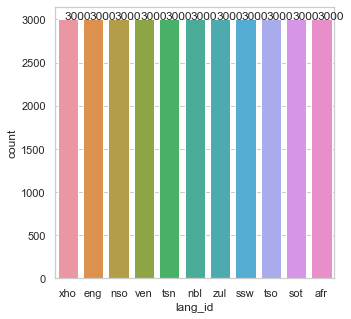

In [6]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=df_train['lang_id'],  data=df_train, order = df_train['lang_id'].value_counts().index )
for p, label in zip(ax.patches, df_train['lang_id'].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

In [7]:
# vect = CountVectorizer()
# X_count = vect.fit_transform(df_train['cleaned_message'].values.astype(str))
vect_20 = CountVectorizer(lowercase=True, max_features = 11000)
X_count = vect_20.fit_transform(df_train['cleaned_message'].values.astype(str))
X_count.shape
X = vect_20.fit_transform(df_train['cleaned_message'].values).toarray()

In [17]:
x = df_train['cleaned_message']
y = df_train['lang_id']
# vectorization clean training data 
vectorizer = TfidfVectorizer(min_df=2,  max_df=0.9,
                             ngram_range=(3, 6), analyzer=('char'))
features = vectorizer.fit_transform(x)
labels = df_train['lang_id']

# Fit label encoder and return encoded labels
le = LabelEncoder()
Y = le.fit_transform(y)
# List of label encoder types to use for lookup 
type_labels = list(le.classes_)



In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, Y,test_size=0.2, random_state = 42)

In [19]:
lm_kbest = LogisticRegression(random_state = 42, multi_class='ovr', n_jobs = 1, C = 1e5, max_iter = 4000)
# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=5000)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y_train)
X_test_kbest = selector_kbest.transform(X_test)


C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\kinyabeta\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [21]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)

test_features = vectorizer.transform(df_test.cleaned_message)
test_features = selector_kbest.transform(test_features)
new_pred = lm_kbest.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred))
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission16.csv')

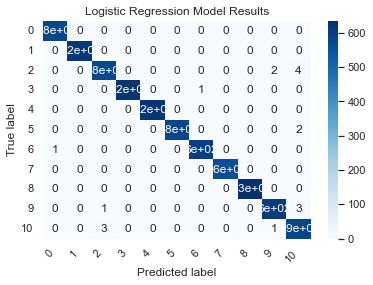

In [26]:
ypred = lm_kbest.predict(selector_kbest.transform(X_test))
conmat = confusion_matrix(y_test, ypred)
val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Logistic Regression Model Results')

plt.show()

In [27]:
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [28]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)

test_features = vectorizer.transform(df_test.text)
new_pred1 = model.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred1))
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission17.csv')

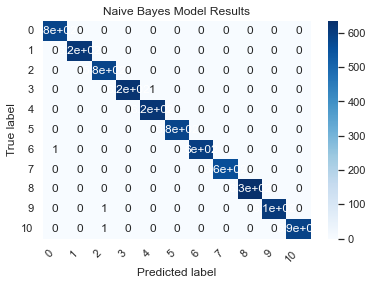

In [29]:
ypred1 = model.predict(X_test)
conmat1 = confusion_matrix(y_test, ypred1)
val1 = np.mat(conmat1) 

classnames1 = list(set(y_train))

df_cm1 = pd.DataFrame(

        val1, index=classnames, columns=classnames, 

    )

plt.figure()

heatmap = sns.heatmap(df_cm1, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Naive Bayes Model Results')

plt.show()

In [30]:
#Logistic regression model for training 
lm_model = LogisticRegression(random_state = 42, multi_class='ovr', n_jobs = 1, C = 1e5, max_iter = 4000)
lm_model.fit(X_train, y_train)


LogisticRegression(C=100000.0, max_iter=4000, multi_class='ovr', n_jobs=1,
                   random_state=42)

In [31]:
df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)
test_features = vectorizer.transform(df_test.cleaned_message)
new_pred2 = lm_model.predict(test_features)

df_test['lang_id'] = list(le.inverse_transform(new_pred2))
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission18.csv')

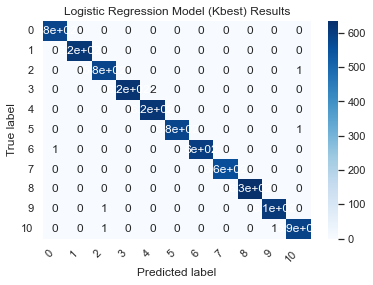

In [32]:
ypred2 = lm_model.predict(X_test)
conmat2 = confusion_matrix(y_test, ypred2)
val2 = np.mat(conmat2) 

classnames2 = list(set(y_train))

df_cm2 = pd.DataFrame(

        val2, index=classnames, columns=classnames, 

    )

plt.figure()

heatmap = sns.heatmap(df_cm2, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Logistic Regression Model (Kbest) Results')

plt.show()

In [33]:
svm_model = LinearSVC(penalty='l2',multi_class='ovr')
svm_model.fit(X_train, y_train)

df_test = pd.read_csv('test_set.csv')
df_test['cleaned_message'] = df_test['text'].apply(clean_title)
test_features = vectorizer.transform(df_test.cleaned_message)
new_pred3 = svm_model.predict(test_features)
df_test['lang_id'] = list(le.inverse_transform(new_pred3))

In [34]:
# df_test.rename(columns={'pred':'lang_id'},inplace=True)
sub = df_test[['index','lang_id']]
sub = sub.set_index('index')
sub.to_csv('Submission19.csv')

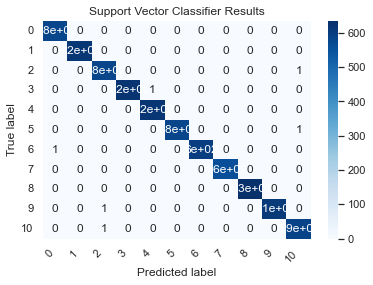

In [35]:
ypred3 = svm_model.predict(X_test)
conmat3 = confusion_matrix(y_test, ypred3)
val3 = np.mat(conmat3) 

classnames3 = list(set(y_train))

df_cm3 = pd.DataFrame(

        val3, index=classnames, columns=classnames, 

    )

plt.figure()

heatmap = sns.heatmap(df_cm3, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Support Vector Classifier Results')

plt.show()

In [36]:
model_names = ['Logistic Regression', 'Logistic regression with K-best features', 'Naive Bayes',  'Linear SVC']
model_list = [lm_model, lm_kbest, model, svm_model]

In [37]:
Testing_performance = []
Training_performance = []
for x in model_list:
    if x == lm_kbest:
        Training_performances = x.score(X_train_kbest, y_train)
        Training_performance.append(Training_performances)
        Testing_performances = x.score(X_test_kbest, y_test)
        Testing_performance.append(Testing_performances)
    else:
        Training_performances = x.score(X_train, y_train)
        Training_performance.append(Training_performances)
        Testing_performances = x.score(X_test, y_test)
        Testing_performance.append(Testing_performances)
dict1 = {'Model': model_names, 'Training Performance': Training_performance, 'Testing Performance': Testing_performance}
Model_df = pd.DataFrame(dict1)

<Figure size 1080x1080 with 0 Axes>

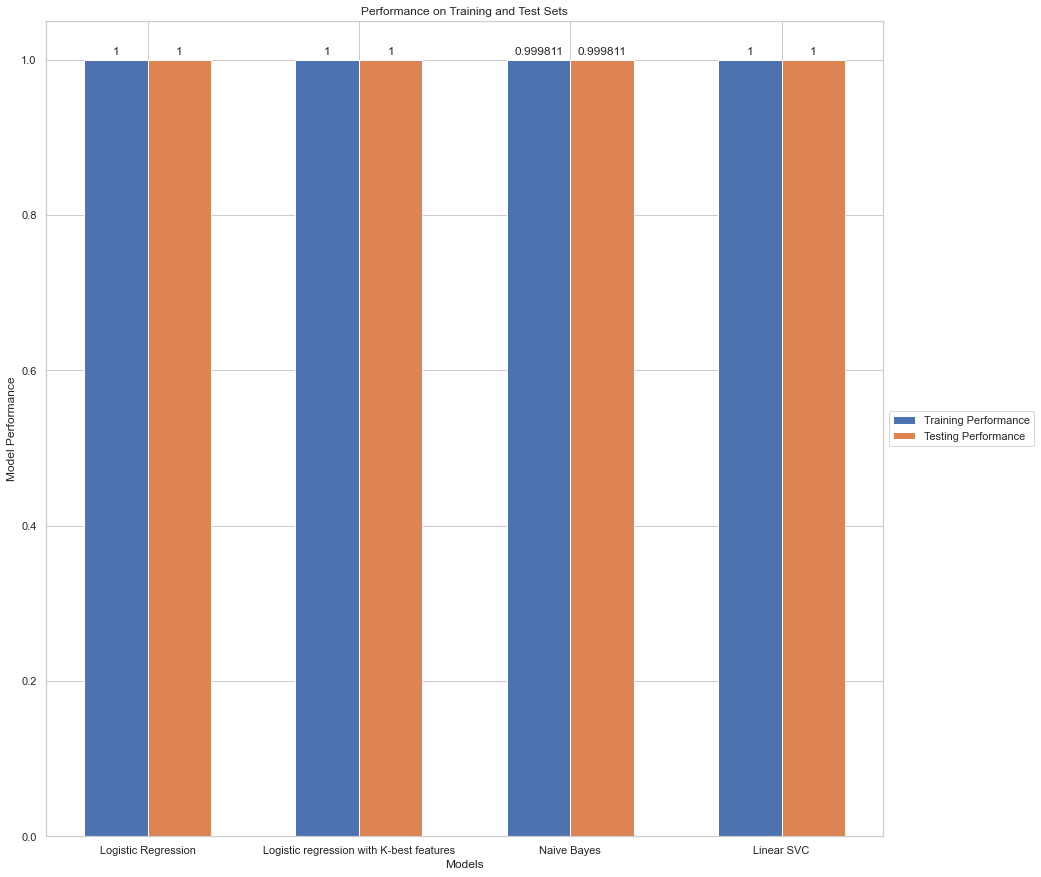

In [46]:

plt.figure(figsize=(15, 15))

x = np.arange(len(model_names))
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects1 = ax.bar(x - width/2, Training_performance, width, label='Training Performance')
rects2 = ax.bar(x + width/2, Training_performance, width, label='Testing Performance')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Performance')
ax.set_xlabel('Models')
ax.set_title('Performance on Training and Test Sets')
ax.set_xticks(x, model_names)
box = ax.get_position()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# fig.tight_layout()

plt.show()